# HW1: Logistic Regression

This class is about models and algorithms for discrete data. This homework will have all 3 ingredients:
* **Data**: the results from all college football games in the 2023 season
* **Model**: The *Bradely-Terry* model for predicting the winners of football game. The Bradley-Terry model is just logistic regression.
* **Algorithm**: We will implement two ways of fitting logistic regression: gradient descent and Newton's method

## The Bradley-Terry Model

In the Bradley-Terry Model, we give team $k$ a team-effect $\beta_k$. Basically, higher $\beta_k$ (relatively speaking), means that team $k$ is a better team.
The Bradley-Terry model formalizes this intution by modeling the log odds of team $k$ beating team $k'$ by the difference in their team effects, $\beta_k - \beta_{k'}$.

Let $i = 1,\ldots, n$ index games, and let $h(i) \in \{1,\ldots,K\}$ and $a(i) \in \{1,\ldots,K\}$ denote the indices of the home and away teams, respectively.
Let $Y_i \in \{0,1\}$ denote whether the home team won.
Under the Bradley-Terry model,
\begin{equation*}
  Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)}) \big),
\end{equation*}
where $\sigma(\cdot)$ is the sigmoid function. We can view this model as a logistic regression model with covariates $x_i \in \mathbb{R}^K$ where,
\begin{align*}
x_{i,k} &=
\begin{cases}
+1 &\text{if } h(i) = k \\
-1 &\text{if } a(i) = k \\
0 &\text{o.w.},
\end{cases}
\end{align*}
and parameters $\beta \in \mathbb{R}^K$.

## Data

We use the results of college football games in the fall 2023 season, which are available from the course github page and loaded for you below.

The data comes as a list of the outcomes of individual games. You'll need to wrangle the data to get it into a format that you can feed into the Bradley-Terry model.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

allgames = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2025/data/01_allgames.csv")

## Problem 0: Preprocessing

Preprocess the data to drop games with nan scores, construct the covariate matrix $X$, construct the response vector $y$, and do any other preprocessing you find useful.

In [3]:
# your code here
allgames = allgames.dropna(subset=['Home Points', 'Away Points'])
teams = pd.concat([allgames['Home Team'], allgames['Away Team']]).unique()
team_to_index = {team: idx for idx, team in enumerate(teams)}
allgames['Home Index'] = allgames['Home Team'].map(team_to_index)
allgames['Away Index'] = allgames['Away Team'].map(team_to_index)
allgames = allgames.reset_index()
X = []
for _, row in allgames.iterrows():
    x = [0] * len(teams)
    x[row['Home Index']] = 1
    x[row['Away Index']] = -1
    X.append(x)

X = torch.tensor(X, dtype=torch.float32)

In [4]:
y = (allgames['Home Points'] > allgames['Away Points']).astype(int).values
y = torch.tensor(y, dtype=torch.float32)
y

tensor([1., 1., 1.,  ..., 1., 0., 1.])

## Problem 1: Loss function

Write a function to compute the loss, $L(\beta)$ defined be

\begin{equation*}
  L(\beta) = -\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid x_i; \beta) + \frac{\gamma}{2} \| \beta \|_2^2
\end{equation*}
where $\gamma$ is a hyperparameter that controls the strength of your $\ell_2$ regularization.

You may want to use the `torch.distributions.Bernoulli` class.

In [5]:
# your code here
def loss(beta, X, y, gamma = 0):
    p = torch.sigmoid(torch.matmul(X, beta))
    Bernoulli = torch.distributions.Bernoulli(p)
    loss = -torch.mean(Bernoulli.log_prob(y)) + gamma * torch.norm(beta, p=2)**2 / 2
    return loss

## Problem 2: Gradient Descent

### Problem 2.1 Implementing and checking your gradients


Write a function to compute the gradient of the average negative log likelihood and check your output against the results obtained by PyTorch's automatic differentiation functionality.

In [6]:
# your code here
def gradient(beta, X, y, gamma = 0, if_sparse = False):
  if if_sparse:
    z = torch.sparse.mm(X, beta.unsqueeze(1)).squeeze(1)
    p = torch.sigmoid(z)
    residual = y - p
    grad = -torch.sparse.mm(X.T, residual.unsqueeze(1)).squeeze(1) / X.shape[0]
    grad += gamma * beta
  else:
    p = torch.sigmoid(torch.matmul(X, beta))
    grad = -torch.matmul(X.T, y - p) / X.shape[0] + gamma * beta
  return grad

##### By the result below, we can see our gradient output works the same as PyTorch's automatic differentiation

In [ ]:
torch.manual_seed(42)
beta = torch.randn(len(teams), requires_grad=True)
gamma = 0.1
loss1 = loss(beta, X, y, gamma) # Call the loss function and store the result
loss1.backward() # Call backward on the result of the loss function, not the function itself

manual_grad = gradient(beta, X, y, gamma, if_sparse = False)

# Compare gradients
print("\nDifference:\n", torch.round(torch.norm(manual_grad - beta.grad, p=2)**2))


Difference:
 tensor(0., grad_fn=<RoundBackward0>)


### Problem 2.2: Implement Gradient Descent


Now, use gradient descent to fit your Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements gradient descent to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curve of your algorithm and a brief discussion if it makes sense or not
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

In [7]:
# your code here (you can use multiple code and markdown cells to organize your answer)
def gradient_descent(X, y, gamma = 0, lr = 0.01, tol = 1e-7, max_iter = 10000, if_sparse = False):
    beta = torch.zeros(X.shape[1], requires_grad=False)
    losses = [loss(beta, X, y, gamma)]
    for i in tqdm(range(max_iter)):
      beta -= lr * gradient(beta, X, y, gamma, if_sparse)
      losses.append(loss(beta, X, y, gamma))
      if abs(losses[-1] - losses[-2]) < tol:
        break
    return beta, losses

In [8]:
def cross_validation(X, y, gamma_grid, function, k = 5, lr = 0.01, if_sparse = False):
  losses = [0] * len(gamma_grid)
  for i in range(len(gamma_grid)):
    total_loss_gamma = 0
    for j in range(k):
      # cut into 5
      test_indices = torch.tensor([idx for idx in range(X.shape[0]) if idx % k == j])
      train_indices = torch.tensor([idx for idx in range(X.shape[0]) if idx not in test_indices])
      test_X = X[test_indices]
      test_y = y[test_indices]
      train_X = X[train_indices]
      train_y = y[train_indices]
      beta, _ = function(train_X, train_y, gamma_grid[i], lr, if_sparse = if_sparse)
      total_loss_gamma += loss(beta, test_X, test_y, gamma_grid[i])
    losses[i] = total_loss_gamma

  best_gamma = gamma_grid[losses.index(min(losses))]
  return best_gamma


In [ ]:
gamma_grid = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
best_gamma = cross_validation(X, y, gamma_grid, gradient_descent, lr = 0.3, if_sparse=True)

  0%|          | 21/10000 [00:00<00:34, 288.79it/s]


In [ ]:
best_gamma

0.001

In [ ]:
beta, losses = gradient_descent(X, y, 0.001, lr = 0.3, if_sparse=True)

 66%|██████▌   | 6613/10000 [00:20<00:10, 321.13it/s]


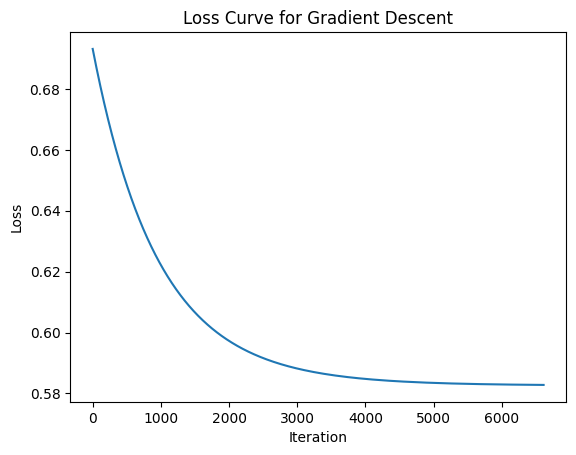

In [ ]:

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Gradient Descent')
plt.show()

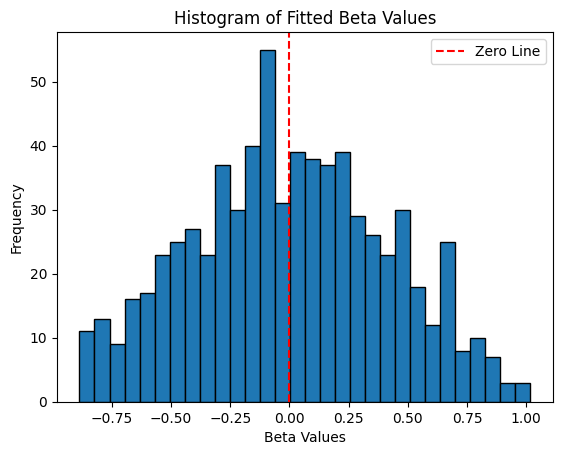

In [ ]:
plt.hist(beta, bins=30, edgecolor='black')  # Add edgecolor for clear bar separation
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')  # Optional vertical reference line

# Add labels and title
plt.xlabel('Beta Values')
plt.ylabel('Frequency')
plt.title('Histogram of Fitted Beta Values')
plt.legend()

# Estimated top 10 Teams are the followings:


In [ ]:
top_10_indices = torch.topk(beta, k=10).indices
top_10_teams = [(float(beta[idx]), teams[idx]) for idx in top_10_indices]
top_10_teams.sort()
print(top_10_teams)

[(0.0, 'Albany'), (0.0, 'Jackson State'), (0.0, 'Jacksonville State'), (0.0, 'Louisiana Tech'), (0.0, 'Mercer'), (0.0, 'New Mexico State'), (0.0, 'Notre Dame'), (0.0, 'San Diego State'), (0.0, 'USC'), (0.0, 'Vanderbilt')]


# True Top 10 Teams are the followings:

In [ ]:
true_top10_winnings = torch.topk(torch.abs(torch.matmul(X.T, y)), k=10).indices
ture_top_10_teams = [teams[idx] for idx in true_top10_winnings]
ture_top_10_teams.sort()
print(ture_top_10_teams)

['Alabama', 'Erskine', 'Florida State', 'Liberty', 'Lincoln University (CA)', 'Michigan', 'South Dakota State', 'Texas', 'Virginia Lynchburg', 'Washington']


In [ ]:
# correctness
print(len(set(ture_top_10_teams).intersection(set(top_10_teams)))/10)

0.7


#### This ranking make sense because it's the team with the top 10 highest $\beta_k$, by the model definition we have $$Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)}) \big)$$
since $\sigma(\cdot)$ is increasing function teams with higher $\beta$
will have a higher prob of winning against teams with lower
$\beta$, and as we can see by using this we can determine $7$ out of $10$ teams correctly.

## Problem 3: Newton's Method

Now, use Newton's method to fit your Bradley-Terry model to the provided data.


### Problem 3.1 The Hessian



#### Problem 3.1.1. Implement and check the Hessian
Write a function to compute the Hessian of the average negative log likelihood and check your answer against the output of `from torch.autograd.functional.hessian`.

In [9]:
# your code here
def hessian(beta, X, y, gamma = 0, if_sparse = False):
  if if_sparse:
    X_sparse = X.to_sparse()
    z = torch.sparse.mm(X_sparse, beta.unsqueeze(1)).squeeze(1)
    p = torch.sigmoid(z)
    diag_entries = p * (1 - p)
    D_sparse = torch.sparse_coo_tensor(
        indices=torch.arange(diag_entries.size(0)).repeat(2, 1),
        values=diag_entries,
        size=(diag_entries.size(0), diag_entries.size(0))
    )
    XT_D = torch.sparse.mm(X_sparse.T, D_sparse)
    H = torch.sparse.mm(XT_D, X_sparse) / X.shape[0]
    H = gamma * torch.eye(X.shape[1]).to(H.device) + H
  else:
    p = torch.sigmoid(torch.matmul(X, beta))
    D = torch.diag(p * (1 - p))
    H = -torch.matmul(X.T, torch.matmul(D, X)) / X.shape[0] + gamma * torch.eye(X.shape[1])

  return H

#### By the result below, we can see our hessian output works the same as PyTorch's automatic hessian

In [ ]:
manual_H = hessian(beta, X, y, if_sparse=True)
auto_H = torch.autograd.functional.hessian(lambda b: loss(b, X, y), beta)
print("\nDifference:\n", torch.round(torch.norm(manual_H - auto_H, p=2)**2))


Difference:
 tensor(0., grad_fn=<RoundBackward0>)


#### Problem 3.1.2: Positive definiteness

Compute the Hessian at the point $\beta = 0$ without regularization (set $\gamma = 0$). Unless you've done sort of pre-processing, it's probably singular.

In [ ]:
# your code here
beta = torch.zeros(X.shape[1], requires_grad=False)
H = hessian(beta, X, y)

#### Problem 3.1.3

Describe intuitively and mathematically what it means for the Hessian of the negative log likelihood to be singular in the context of this data and model

## Intuitively: When $\beta=0$ and $\gamma=0$, the matrix $W$ with diagonal $\sigma(X\beta)=\sigma(\mathbf{0})$ is a constant and no $\gamma I$ term, so $H$ if singular or not only depend on $X^TX$. In this model, the total number of home games (labeled +1) and away games (labeled -1) are the same, based on how we define for the $X$, the sum of all column of $X$ is equal to $0$, so columns are not linearly independent so it's singular.

## Mathematically

When the $\beta=0$ and $\gamma=0$, so the vector $p=\sigma(X\beta)=\sigma(\mathbf{0})=\mathbf{0.5}$, so in the hessian our $W=diag(p_1(1-p_1),....,p_k(1-p_k))=diag(0.25,....,0.25)$:
\begin{align}
H=\frac{1}{n}X^T W X +\gamma I=\frac{1}{4n}X^TX
\end{align}
Note that for each row of $X$, it only contain an $1$ and a $-1$, others are $0$, then we can consider $\mathbf{1}_k$. By this construction we have $X\mathbf{1}=\mathbf{0}$, then
$$
H\mathbf{1}=\frac{1}{4n}X^TX\mathbf{1}_k=\big(\frac{1}{4n}X^T\big)X\mathbf{1}_k=\frac{1}{4n}X^T \mathbf{0}=\mathbf{0}_k
$$
so $\mathbf{1}_k$ is in the kernal of $H$, by rank–nullity theorem $H$ does column rank at most $k-1$, which is not full rank, so it's singular.

#### Problem 3.1.4

Give a hypothesis for why the Hessian in this dataset and model is singular, and provide empirical evidence to support your hypothesis.

#### This Hessian has determinant $0$, the results as follows:

In [ ]:
det = torch.linalg.det(H)
if torch.isclose(det, torch.tensor(0.0)):
    print("The matrix is singular (det = 0).")
else:
    print("The matrix is not singular (det ≠ 0).")

The matrix is singular (det = 0).


#### Problem 3.1.5

Explain why the Hessian is invertible when $\gamma > 0$.

When $\gamma>0$, then for any $u\neq 0$ we have $\| u\|_2^2>0$
\begin{align}
u^THu=\frac{1}{n}u^T X^T W Xu +\gamma u^TIu=\frac{1}{n} \|W^{1/2}Xu \|_2^2 + \gamma \| u\|_2^2\geq \gamma \| u\|_2^2 > 0
\end{align}
so in this case $H$ is positive definite, which is invertible.

### Problem 3.2: Implement Newton's method

Now, use Newton's method to fit your $\ell_2$-regularized Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements Newton's method to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curves from Newton's method and from gradient descent, using the same regularization strength $\gamma$ and initialization $\beta_0$. Briefly discuss the results and compare their rates of convergence.
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

In [10]:
# your code here (you can use multiple code and markdown cells to organize your answer)
def newton_method(X, y, gamma = 0, lr = 1, tol = 1e-7, max_iter = 10000, if_sparse = False):
    beta = torch.zeros(X.shape[1], requires_grad=False)
    losses = [loss(beta, X, y, gamma)]
    for i in tqdm(range(max_iter)):
      H = hessian(beta, X, y, gamma, if_sparse=if_sparse)
      beta -= lr * torch.linalg.solve(H, gradient(beta, X, y, gamma, if_sparse=if_sparse))
      losses.append(loss(beta, X, y, gamma))
      if abs(losses[-1] - losses[-2]) < tol:
        break
    return beta, losses

In [12]:
beta_newton, losses_newton = newton_method(X, y, 0.001, lr=0.005, if_sparse=True)

  9%|▉         | 877/10000 [00:17<03:01, 50.17it/s]


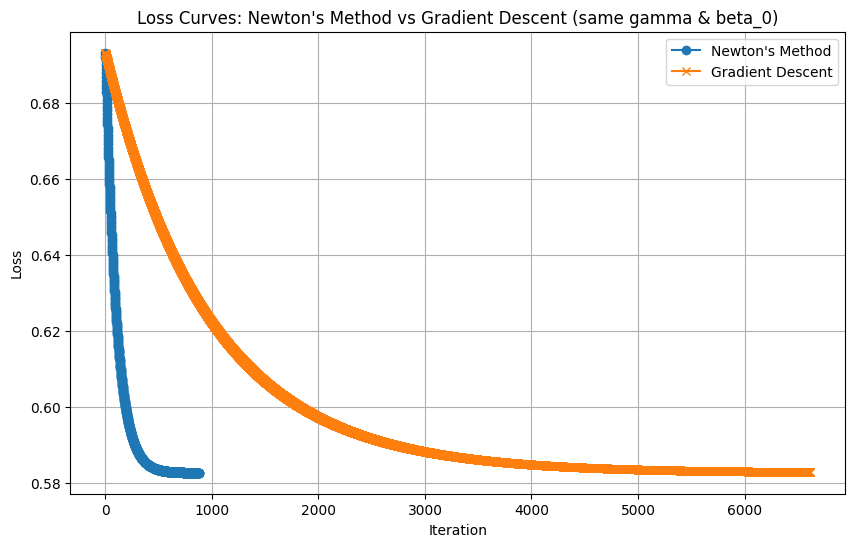

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses_newton)), losses_newton, label="Newton's Method", marker='o')
plt.plot(range(len(losses)), losses, label="Gradient Descent", marker='x')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curves: Newton\'s Method vs Gradient Descent (same gamma & beta_0)')
plt.legend()
plt.grid()
plt.show()

## As we can see the number of iteration for gradident descent is close to 7000, and number of iteration for Newton's method is around 850, note that $850^2$ is approxinatly 7000. According to what we learned, gradient descent is linear rate of convergence while Newton's method is quadratic rate of convergence, so our result match these convergence rates.

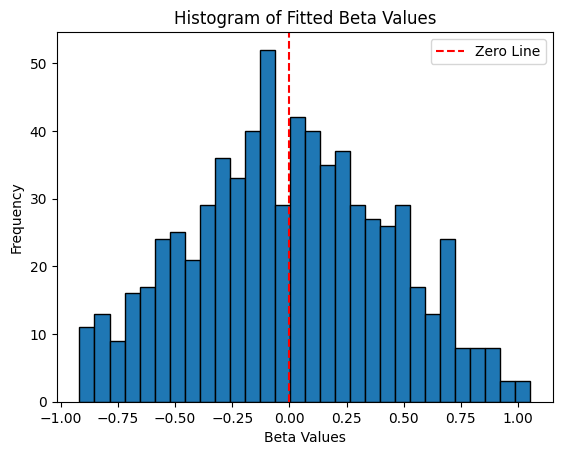

In [ ]:
plt.hist(beta_newton, bins=30, edgecolor='black')  # Add edgecolor for clear bar separation
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')  # Optional vertical reference line

# Add labels and title
plt.xlabel('Beta Values')
plt.ylabel('Frequency')
plt.title('Histogram of Fitted Beta Values')
plt.legend()

# Estimated Top 10 Teams are the followings:


In [ ]:
newton_top_10_indices = torch.topk(beta_newton, k=10).indices
newton_top_10_teams = [teams[idx] for idx in newton_top_10_indices]
newton_top_10_teams.sort()
print(newton_top_10_teams)

['Alabama', 'Colorado Mines', 'Florida State', 'Georgia', 'Johns Hopkins', 'Liberty', 'Michigan', 'South Dakota State', 'Texas', 'Washington']


# True Top 10 Teams are the followings:

In [ ]:
print(ture_top_10_teams)

['Alabama', 'Erskine', 'Florida State', 'Liberty', 'Lincoln University (CA)', 'Michigan', 'South Dakota State', 'Texas', 'Virginia Lynchburg', 'Washington']


In [ ]:
# correctness
print(len(set(ture_top_10_teams).intersection(set(newton_top_10_teams)))/10)

0.7


In [ ]:
# compare with gradient descent
set(newton_top_10_teams) == set(top_10_teams)

True

#### This ranking make sense because it's the team with the top 10 highest $\beta_k$, by the model definition we have $$Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)}) \big)$$
since $\sigma(\cdot)$ is increasing function teams with higher $\beta$
will have a higher prob of winning against teams with lower
$\beta$, and as we can see by using this we can determine $7$ out of $10$ teams correctly, and the result from Newton's method iteration matches with the results from gradident descent

## Problem 4: Model criticism and revision

Let's take another look the Bradley-Terry model from earlier and think about improvements we can make.


### Problem 4.1: Improvements to Bradley-Terry Model
Choose one way to improve the Bradley-Terry model. Discuss *a priori* why you think this change will improve the model and implement your change.

I think we can add more useful variables into the model, for example both team's **Pregame Elo**. That is because the Elo calculates the relative skill levels of players in zero-sum games, so knowing the skills level for both side is helpful to determine the winning probability.  However, the measurement for Elo seems a bit hard to interpret, so we cosider the Elo ratio for both teams:

$$
EloR_{home}=\frac{Elo_{home}}{Elo_{home}+Elo_{Away}} \ \ \ \ \ \ \ \textbf{and}\ \ \ \ \ \ \ EloR_{Away}=\frac{Elo_{Away}}{Elo_{home}+Elo_{Away}}
$$
this can shows a "relative" value between two teams the Elo scores, and easy for us to compare. Now we add the following variable into the model
$$
EloRDiff = EloR_{home} - EloR_{Away}
$$
Now put this into the original Bradley-Terry model, we will have
$$Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)} + \beta_d \cdot EloRDiff) \big)$$

In [ ]:
# fill pregame elo with col median
allgames["Home Pregame Elo"] = allgames["Home Pregame Elo"].fillna(allgames["Home Pregame Elo"].median())
allgames["Away Pregame Elo"] = allgames["Away Pregame Elo"].fillna(allgames["Away Pregame Elo"].median())

In [ ]:
allgames["Elo_sum"] = allgames["Home Pregame Elo"] + allgames["Away Pregame Elo"]
allgames["EloR_home"] = allgames["Home Pregame Elo"] / allgames["Elo_sum"]
allgames["EloR_away"] = allgames["Away Pregame Elo"] / allgames["Elo_sum"]
allgames["EloRDiff"] = allgames["EloR_home"] - allgames["EloR_away"]

In [ ]:
# add EloRDiff col to data
EloRDiff = torch.tensor(allgames["EloRDiff"].values, dtype=torch.float32)

In [ ]:
Combined_X = torch.cat((X, EloRDiff.unsqueeze(1)), dim=1)

In [ ]:
# Train, Test split
train_indices = torch.tensor([idx for idx in range(X.shape[0]) if idx % 5 != 0])
test_indices = torch.tensor([idx for idx in range(X.shape[0]) if idx % 5 == 0])

In [ ]:
X_train = X[train_indices]
y_train = y[train_indices]
Combined_X_train = Combined_X[train_indices]
Combined_X_test = Combined_X[test_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [ ]:
improved_beta, improved_losses = newton_method(Combined_X_train, y_train, 0.001, lr=0.1, if_sparse=True)
original_beta, original_losses = newton_method(X_train, y_train, 0.001, lr=0.1, if_sparse=True)

  1%|          | 59/10000 [00:01<03:33, 46.50it/s]


### Problem 4.2: Evaluation
Assess whether or not your change was an improvement or not. Provide empirical evidence by evaluating performance on a held out test set and include at least one plot supporting your assessment.

## As we can see, the modified model has less loss than the original model over the iteration

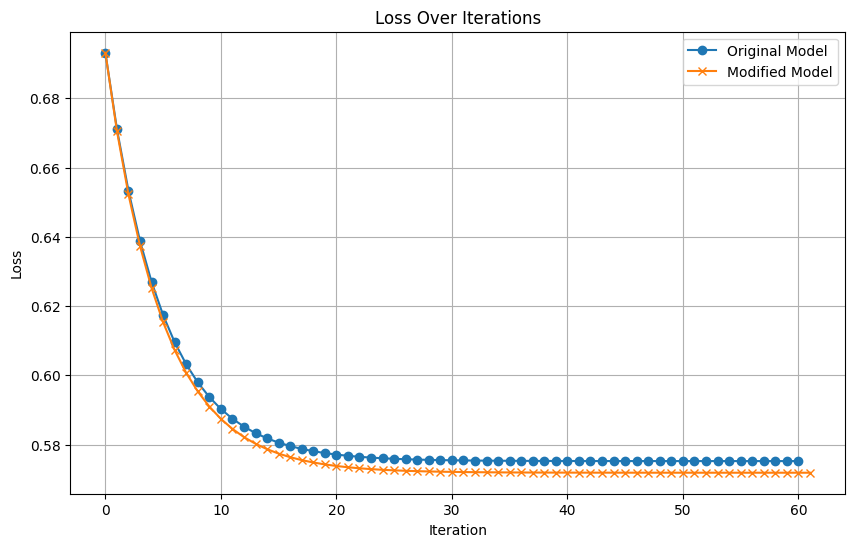

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(original_losses, label="Original Model", marker='o')
plt.plot(improved_losses, label="Modified Model", marker='x')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Iterations')
plt.legend()
plt.grid()
plt.show()

# The following plots shows the distribution of $\beta$ in both model are very close.

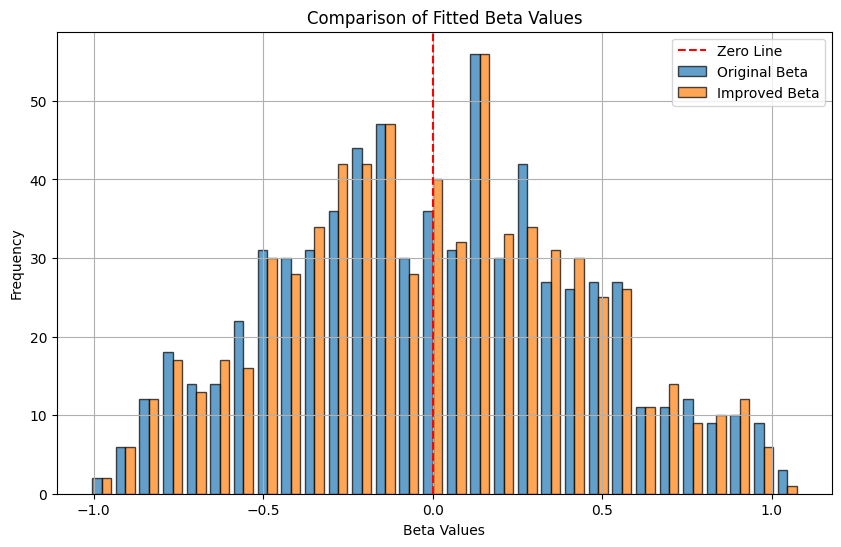

In [ ]:
bins = 30
original_hist, bin_edges = torch.histogram(original_beta, bins=bins)
improved_hist, _ = torch.histogram(improved_beta[:-1], bins=bin_edges)

# Shift the bins slightly for side-by-side comparison
width = (bin_edges[1] - bin_edges[0]) * 0.4
x_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.bar(x_centers - width / 2, original_hist.numpy(), width=width, label='Original Model Beta', alpha=0.7, edgecolor='black')
plt.bar(x_centers + width / 2, improved_hist.numpy(), width=width, label='Modified Model Beta', alpha=0.7, edgecolor='black')

# Add labels, title, and legend
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')  # Optional reference line
plt.xlabel('Beta Values')
plt.ylabel('Frequency')
plt.title('Comparison of Fitted Beta Values')
plt.legend()
plt.grid()
plt.show()

# The following results show our modified model has better performance on test sets in both Log-Loss and accuracy, but the performance improvement is very small, which is not significant.

In [ ]:
# Log loss
improved_test_loss = loss(improved_beta, Combined_X_test, y_test)
original_test_loss = loss(original_beta, X_test, y_test)

# Accuracy
improved_accuracy = torch.mean(((torch.sigmoid(torch.matmul(Combined_X_test, improved_beta)) > 0.5) == y_test).type(torch.float32)).item()
original_accuracy = torch.mean(((torch.sigmoid(torch.matmul(X_test, original_beta)) > 0.5) == y_test).type(torch.float32)).item()

In [ ]:
improved_test_loss, original_test_loss

(tensor(0.5808), tensor(0.5831))

In [ ]:
improved_accuracy, original_accuracy

(0.7242339849472046, 0.7186629772186279)

In [ ]:
if (improved_test_loss - original_test_loss) < 0:
  print("Improved Model has lower Log-Loss: Loss Difference = {}".format(float(improved_test_loss - original_test_loss)))
if (improved_accuracy - original_accuracy) > 0:
  print("Improved Model has higher Accuracy: Accuracy Difference = {}".format(float(improved_accuracy - original_accuracy)))

Improved Model has lower Log-Loss: Loss Difference = -0.0023246407508850098
Improved Model has higher Accuracy: Accuracy Difference = 0.00557100772857666


# After comparing estimated top 10 teams with the true top 10 teams (based on number of wining games), both model does not have very good estimation for top 10 teams; moreover, original model is getting 6 correct of top 10 team while the modified model can only get 2.

In [ ]:
improved_top_10_indices = torch.topk(improved_beta[:-1], k=10).indices
improved_top_10_teams = [(float(improved_beta[:-1][idx]), teams[idx]) for idx in improved_top_10_indices]
improved_top_10_teams.sort(key= lambda x: (-x[0], x[1]))

original_top_10_indices = torch.topk(original_beta, k=10).indices
original_top_10_teams = [(float(original_beta[idx]), teams[idx]) for idx in original_top_10_indices]
original_top_10_teams.sort(key= lambda x: (-x[0], x[1]))

true_top10_winnings = torch.topk(torch.abs(torch.matmul(X.T, y)), k=10).indices
ture_top_10_teams = [(int(torch.abs(torch.matmul(X.T, y))[idx]) , teams[idx]) for idx in true_top10_winnings]
ture_top_10_teams.sort(key= lambda x: (-x[0], x[1]))

Ranking_Table = pd.DataFrame({ "true_ranking": [t[1] for t in ture_top_10_teams],
                             "winning_count": [t[0] for t in ture_top_10_teams],
                              "modified_model_ranking": [t[1] for t in improved_top_10_teams],
                             "modified_model_beta": [t[0] for t in improved_top_10_teams],
                             "original_model_ranking": [t[1] for t in original_top_10_teams],
                             "original_model_beta": [t[0] for t in original_top_10_teams]})

In [ ]:
Ranking_Table

,true_ranking,winning_count,modified_model_ranking,modified_model_beta,original_model_ranking,original_model_beta
0,Lincoln University (CA),11,Missouri,1.013195,Alabama,1.080783
1,Virginia Lynchburg,9,South Dakota State,1.002020,Ohio State,1.048067
2,Florida State,8,Susquehanna,0.988246,Missouri,1.012734
3,Liberty,8,Johns Hopkins,0.984934,Florida State,1.005409
4,Washington,8,Alabama,0.969928,South Dakota State,1.002152
5,Alabama,7,Colorado Mines,0.949031,Susquehanna,0.988251
6,Erskine,7,Alma College,0.943580,Johns Hopkins,0.984118
7,Michigan,7,Ohio State,0.938690,Texas,0.981370
8,South Dakota State,7,Mount Union,0.935198,Michigan,0.974979
9,Texas,7,Valdosta State,0.932693,Washington,0.956092


In [ ]:
# correctness - original
print(len(set([x[1] for x in ture_top_10_teams]).intersection(set([x[1] for x in original_top_10_teams])))/10)

0.6


In [ ]:
# correctness - modified
print(len(set([x[1] for x in ture_top_10_teams]).intersection(set([x[1] for x in improved_top_10_teams])))/10)

0.2


# According to the above empirical result, our modified model does not have improvement in the estimation, both modified and original models have almost the same level of performance but modified model does not estimate the top 10 team well.

### Problem 4.3: Reflection
Reflecting on the analysis we've conducted in this assignemnt, which conference is best? Is there a significant difference? Please justify your answer.

In [99]:
allgames = allgames.dropna(subset=['Home Conference', 'Away Conference'])

In [100]:
Conferences = set(allgames["Home Conference"].unique()).union(set(allgames["Away Conference"].unique()))
Conferences_betas_group = set()
for _, row in allgames.iterrows():
  Conferences_betas_group.add((row["Home Conference"], team_to_index[row["Home Team"]], float(beta_newton[team_to_index[row["Home Team"]]])))
  Conferences_betas_group.add((row["Away Conference"], team_to_index[row["Away Team"]], float(beta_newton[team_to_index[row["Away Team"]]])))

In [101]:
Conferences_betas_df = pd.DataFrame(Conferences_betas_group, columns=["Conference", "Team", "Beta"])

In [102]:
Conferences_betas_df

,Conference,Team,Beta
0,Big Ten,347,0.856837
1,American Athletic,197,-0.470199
2,Big Sky,611,-0.387087
3,CAA,5,0.409213
4,FBS Independents,65,-0.434167
...,...,...,...
660,NEWMAC,652,-0.632897
661,CIAA,425,0.413956
662,Mid Atlantic,575,0.468969
663,Commonwealth Coast,341,0.499442


In [107]:
Conference_group = Conferences_betas_df.groupby("Conference")

In [108]:
# get max average beta in group
Conferences_betas = {cf_name : torch.tensor(cf_group["Beta"].values, dtype=torch.float32) for cf_name, cf_group in Conference_group}

In [109]:
Conferences_betas_mean = {cf_names : torch.mean(torch.stack((betas,))) for cf_names, betas in Conferences_betas.items()} # Wrap betas in a tuple
Best_Conference = max(Conferences_betas_mean, key=Conferences_betas_mean.get)
Best_Conference, float(Conferences_betas_mean[Best_Conference])

('SEC', 0.2739911675453186)

## From the above result we see that, the **SEC** conference is the best since the teams in this conference have the highest average $\beta=0.2739911675453186$

## Here we perform a one-way F-test to determine if there exists significant differences between the conference based on the team's $\beta_k$

That is we want to test:

$$
H_0: \ \ \bar{\beta}_{c_1}=\bar{\beta}_{c_2}=...=\bar{\beta}_{c_n}\ \ \ \ \ vs \ \ \ \ \ H_\alpha: \ \ \text{exist $\bar{\beta}_{c_k}$ different from the rest}
$$

In [110]:
from scipy.stats import f_oneway
f_stat, p_value = f_oneway(*Conferences_betas.values())
f_stat, p_value

(0.7197656689609921, 0.9566519398081665)

We can see that p-value$\approx 0.956>0.05$, so we cannot reject $H_0$, therefore there is no significent difference between the conferences.